In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch_geometric.utils as tg
import networkx as nx
import torch_geometric
from utils import *
from tqdm import tqdm
import argparse
import scipy
import multiprocessing as mp

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
parser = argparse.ArgumentParser(description='Training GCN on Cora/CiteSeer/PubMed/Reddit Datasets')

'''
    Dataset arguments
'''
parser.add_argument('--dataset', type=str, default='cora',
                    help='Dataset name: cora/citeseer/pubmed/Reddit')
parser.add_argument('--nhid', type=int, default=256,
                    help='Hidden state dimension')
parser.add_argument('--epoch_num', type=int, default= 100,
                    help='Number of Epoch')
# parser.add_argument('--pool_num', type=int, default= 10,
                    # help='Number of Pool')
parser.add_argument('--pool_num', type=int, default= 1,
                    help='Number of Pool')
# parser.add_argument('--batch_num', type=int, default= 10,
#                     help='Maximum Batch Number')
parser.add_argument('--batch_num', type=int, default= 1,
                    help='Maximum Batch Number')
parser.add_argument('--batch_size', type=int, default=512,
                    help='size of output node in a batch')
parser.add_argument('--n_layers', type=int, default=5,
                    help='Number of GCN layers')
parser.add_argument('--n_iters', type=int, default=1,
                    help='Number of iteration to run on a batch')
parser.add_argument('--n_stops', type=int, default=200,
                    help='Stop after number of batches that f1 dont increase')
parser.add_argument('--samp_num', type=int, default=64,
                    help='Number of sampled nodes per layer')
parser.add_argument('--sample_method', type=str, default='ladies',
                    help='Sampled Algorithms: ladies/fastgcn/full')
parser.add_argument('--cuda', type=int, default=-1,
                    help='Avaiable GPU ID')
parser.add_argument('--filename', type = str, default='untitled.txt', help = 'Output file name')


args = parser.parse_args("")

In [4]:
class GraphConvolution(nn.Module):
    def __init__(self, n_in, n_out, bias=True):
        super(GraphConvolution, self).__init__()
        self.n_in  = n_in
        self.n_out = n_out
        self.linear = nn.Linear(n_in,  n_out)
    def forward(self, x, adj):
        out = self.linear(x)
        return F.elu(torch.spmm(adj, out))


class GCN(nn.Module):
    def __init__(self, nfeat, nhid, layers, dropout):
        super(GCN, self).__init__()
        self.layers = layers
        self.nhid = nhid
        self.gcs = nn.ModuleList()
        self.gcs.append(GraphConvolution(nfeat,  nhid))
        self.dropout = nn.Dropout(dropout)
        for i in range(layers-1):
            self.gcs.append(GraphConvolution(nhid,  nhid))
    def forward(self, x, adjs):
        '''
            The difference here with the original GCN implementation is that
            we will receive different adjacency matrix for different layer.
        '''
        for idx in range(len(self.gcs)):
            x = self.dropout(self.gcs[idx](x, adjs[idx]))
        return x

class SuGCN(nn.Module):
    def __init__(self, encoder, num_classes, dropout, inp):
        super(SuGCN, self).__init__()
        self.encoder = encoder
        self.dropout = nn.Dropout(dropout)
        self.linear  = nn.Linear(self.encoder.nhid, num_classes)
    def forward(self, feat, adjs):
        x = self.encoder(feat, adjs)
        x = self.dropout(x)
        x = self.linear(x)
        return x

In [56]:
def fastgcn_sampler(seed, batch_nodes, samp_num_list, num_nodes, lap_matrix, depth):
    '''
        FastGCN_Sampler: Sample a fixed number of nodes per layer. The sampling probability (importance)
                         is pre-computed based on the global degree (lap_matrix)
    '''
    np.random.seed(seed)
    previous_nodes = batch_nodes
    adjs  = []
    #     pre-compute the sampling probability (importance) based on the global degree (lap_matrix)
    pi = np.array(np.sum(lap_matrix.multiply(lap_matrix), axis=0))[0]
    p = pi / np.sum(pi)
    '''
        Sample nodes from top to bottom, based on the pre-computed probability. Then reconstruct the adjacency matrix.
    '''
    for d in range(depth):
        #     row-select the lap_matrix (U) by previously sampled nodes
        U = lap_matrix[previous_nodes , :]
        #     sample the next layer's nodes based on the pre-computed probability (p).
        s_num = np.min([np.sum(p > 0), samp_num_list[d]])
        after_nodes = np.random.choice(num_nodes, s_num, p = p, replace = False)
        #     col-select the lap_matrix (U), and then devided by the sampled probability for 
        #     unbiased-sampling. Finally, conduct row-normalization to avoid value explosion.         
        adj = row_norm(U[: , after_nodes].multiply(1/p[after_nodes]))
        #     Turn the sampled adjacency matrix into a sparse matrix. If implemented by PyG
        #     This sparse matrix can also provide index and value.
        adjs += [sparse_mx_to_torch_sparse_tensor(row_normalize(adj))]
        #     Turn the sampled nodes as previous_nodes, recursively conduct sampling.
        previous_nodes = after_nodes
    #     Reverse the sampled probability from bottom to top. Only require input how the lastly sampled nodes.
    adjs.reverse()
    return adjs, previous_nodes, batch_nodes

def ladies_sampler(seed, batch_nodes, samp_num_list, num_nodes, lap_matrix, depth, prob_norm):
    '''
        LADIES_Sampler: Sample a fixed number of nodes per layer. The sampling probability (importance)
                         is computed adaptively according to the nodes sampled in the upper layer.
    '''
    np.random.seed(seed)
    previous_nodes = batch_nodes
    adjs  = []
    print ('depth', depth)
    '''
        Sample nodes from top to bottom, based on the probability computed adaptively (layer-dependent).
    '''
    for d in range(depth):
        
        #     row-select the lap_matrix (U) by previously sampled nodes
        #U = lap_matrix[previous_nodes , :]
        #    Only use the upper layer's neighborhood to calculate the probability.
        #pi = np.array(np.sum(U.multiply(U), axis=0))[0]
        #p = pi / np.sum(pi)
        #--------------------------------------------------------------------------------
        ''' finding the neighbors. We will find an array of size number of nodes in the graph
            in which only neighors of previous can have non zero probability. Non neighbors 
            should have zero probability. 
        '''
        temp_lap = lap_matrix
        # selecting only rows of nodes previous nodes to find neighbors of only those nodes.
        temp = temp_lap[previous_nodes, :]
        # Summing will give us non zero entries in respective columns if they are neighbors
        # ravel will convert it to 1D array
        nbrs = np.ravel(np.sum(temp, axis = 0))
        # entries in array/list can be lesser/greater than 1, making them 1 if node is neighbor
        # 0 elsewise
        for i in range(len(nbrs)):
            if nbrs[i]>0:
                nbrs[i] = 1
        # Multiply elementwise will give us array with neigbors with probability, 0 for non neighbors
        pi = np.multiply(nbrs, prob_norm)    
        # normalization
        p = pi / np.linalg.norm(pi, ord = 1)

        #--------------------------------------------------------------------------------
        s_num = np.min([np.sum(p > 0), samp_num_list[d]])
        #     sample the next layer's nodes based on the adaptively probability (p).
        after_nodes = np.random.choice(num_nodes, s_num, p = p, replace = False)
        #     Add output nodes for self-loop
        after_nodes = np.unique(np.concatenate((after_nodes, batch_nodes)))
        #     col-select the lap_matrix (U), and then devided by the sampled probability for 
        #     unbiased-sampling. Finally, conduct row-normalization to avoid value explosion.      
        adj = temp[: , after_nodes].multiply(1/p[after_nodes])
        new_adj = sparse_mx_to_torch_sparse_tensor(row_normalize(adj))
        adjs += [new_adj]
        
        #     Turn the sampled nodes as previous_nodes, recursively conduct sampling.
        previous_nodes = after_nodes
    #     Reverse the sampled probability from bottom to top. Only require input how the lastly sampled nodes.
    adjs.reverse()
    return adjs, previous_nodes, batch_nodes

def default_sampler(seed, batch_nodes, samp_num_list, num_nodes, lap_matrix, depth):
    mx = sparse_mx_to_torch_sparse_tensor(lap_matrix)
    return [mx for i in range(depth)], np.arange(num_nodes), batch_nodes


In [57]:
def prepare_data(pool, sampler, process_ids, train_nodes, valid_nodes, samp_num_list, num_nodes, lap_matrix, depth, prob_norm):
    jobs = []
    for _ in process_ids:
        idx = torch.randperm(len(train_nodes))[:args.batch_size]
        batch_nodes = train_nodes[idx]
        p = pool.apply_async(sampler, args=(np.random.randint(2**32 - 1), batch_nodes, samp_num_list, num_nodes, lap_matrix, depth, prob_norm))
        jobs.append(p)
    idx = torch.randperm(len(valid_nodes))[:args.batch_size]
    batch_nodes = valid_nodes[idx]
    p = pool.apply_async(sampler, args=(np.random.randint(2**32 - 1), batch_nodes, samp_num_list * 20, num_nodes, lap_matrix, depth, prob_norm))
    jobs.append(p)
    return jobs

def package_mxl(mxl, device):
    return [torch.sparse.FloatTensor(mx[0], mx[1], mx[2]).to(device) for mx in mxl]

In [58]:
f = open(args.filename, 'w')

if args.cuda != -1:
    device = torch.device("cuda:" + str(args.cuda))
else:
    device = torch.device("cpu")

In [59]:
print(args.dataset, args.sample_method)

cora ladies


In [60]:
edges, labels, feat_data, num_classes, train_nodes, valid_nodes, test_nodes = load_data(args.dataset)

In [61]:
adj_matrix = get_adj(edges, feat_data.shape[0])

In [62]:
lap_matrix = row_normalize(adj_matrix + sp.eye(adj_matrix.shape[0]))
if type(feat_data) == scipy.sparse.lil.lil_matrix:
    feat_data = torch.FloatTensor(feat_data.todense()).to(device) 
else:
    feat_data = torch.FloatTensor(feat_data).to(device)
labels    = torch.LongTensor(labels).to(device) 

In [63]:
if args.sample_method == 'ladies':
    sampler = ladies_sampler
elif args.sample_method == 'fastgcn':
    sampler = fastgcn_sampler
elif args.sample_method == 'full':
    sampler = default_sampler

In [13]:
#------------------------------------------------------
# Modifications to original code

# converting to torch graph
adj_torch = torch_geometric.data.Data(edge_index = torch.tensor([edges[:,0], edges[:,1]]))
# converting to networkx graph
adj_nx = tg.to_networkx(adj_torch)
adj_nx.num_nodes = feat_data.shape[0]

# calculating centralities
eigen_cen = list(nx.eigenvector_centrality(adj_nx).values())
bet_cen = list(nx.betweenness_centrality(adj_nx).values())
clos_cen = list(nx.closeness_centrality(adj_nx).values())
deg_cen = list(nx.degree_centrality(adj_nx).values())
cen = [eigen_cen, bet_cen, clos_cen, deg_cen]


In [64]:
i = 0
# This function will be called by Bayesian optimization
def ladies_iterate(x):
    global cen
    global i
    print('iteration number', i)
    i += 1

    eigen_cen = cen[0]
    bet_cen = cen[1]
    clos_cen = cen[2]
    deg_cen = cen[3]
# Adding linearly to calculate probability
    a = x[0]
    b = x[1]
    c = x[2]
    d = x[3]
    a = a / (a+b+c+d)
    b = b / (a+b+c+d)
    c = c / (a+b+c+d)
    d = d / (a+b+c+d)
    f.write('-----------------------------------------------------------------\n')
    print('-------------------------------------------------------------------')
    strn = 'a = '+ str(a) + ', b = '+ str(b) + ', c = '+ str(c) + ', d = ' + str(d) + '\n'
    f.write(strn)
    print('a = '+ str(a) + ' b = '+ str(b) + ' c = '+ str(c) + ', d = ' +  str(d) + '\n')
    prob_unnorm = a * np.array(eigen_cen) + b * np.array(bet_cen) + c * np.array(clos_cen) + d * np.array(deg_cen)

    prob_norm = prob_unnorm / np.linalg.norm( prob_unnorm, ord = 1 )

    process_ids = np.arange(args.batch_num)
    samp_num_list = np.array([args.samp_num, args.samp_num, args.samp_num, args.samp_num, args.samp_num])

    pool = mp.Pool(args.pool_num)
    jobs = prepare_data(pool, sampler, process_ids, train_nodes, valid_nodes, samp_num_list, len(feat_data), lap_matrix, args.n_layers, prob_norm)
#     all_res = []
#     for oiter in range(1):
#         encoder = GCN(nfeat = feat_data.shape[1], nhid=args.nhid, layers=args.n_layers, dropout = 0.2).to(device)
#         susage  = SuGCN(encoder = encoder, num_classes=num_classes, dropout=0.5, inp = feat_data.shape[1])
#         susage.to(device)
        
#         optimizer = optim.Adam(filter(lambda p : p.requires_grad, susage.parameters()))
#         best_val = 0
#         best_tst = -1
#         cnt = 0
#         times = []
#         res   = []
#         print('-' * 10)
#         for epoch in np.arange(args.epoch_num):
#             susage.train()
#             train_losses = []
#             train_data = [job.get() for job in jobs[:-1]]
#             valid_data = jobs[-1].get()
#             pool.close()
#             pool.join()
#             pool = mp.Pool(args.pool_num)
#             '''
#                 Use CPU-GPU cooperation to reduce the overhead for sampling. (conduct sampling while training)
#             '''
#             jobs = prepare_data(pool, sampler, process_ids, train_nodes, valid_nodes, samp_num_list, len(feat_data), lap_matrix, args.n_layers, prob_norm)
#             for _iter in range(args.n_iters):
#                 for adjs, input_nodes, output_nodes in train_data:    
#                     adjs = package_mxl(adjs, device)
#                     optimizer.zero_grad()
#                     t1 = time.time()
#                     susage.train()
#                     output = susage.forward(feat_data[input_nodes], adjs)
                
#                     if args.sample_method == 'full':
#                         output = output[output_nodes]
#                     loss_train = F.cross_entropy(output, labels[output_nodes])
                
#                     loss_train.backward()
#                     torch.nn.utils.clip_grad_norm_(susage.parameters(), 0.2)
#                     optimizer.step()
#                     times += [time.time() - t1]
#                     train_losses += [loss_train.detach().tolist()]
#                     del loss_train
#             susage.eval()
#             adjs, input_nodes, output_nodes = valid_data
#             adjs = package_mxl(adjs, device)
#             output = susage.forward(feat_data[input_nodes], adjs)
#             if args.sample_method == 'full':
#                 output = output[output_nodes]
#             loss_valid = F.cross_entropy(output, labels[output_nodes]).detach().tolist()
#             valid_f1 = f1_score(output.argmax(dim=1).cpu(), labels[output_nodes].cpu(), average='micro')
#             print(("Epoch: %d (%.1fs) Train Loss: %.2f    Valid Loss: %.2f Valid F1: %.3f") %                   (epoch, np.sum(times), np.average(train_losses), loss_valid, valid_f1))
#             st = ('Epoch: %d (%.1fs) Train Loss: %.2f    Valid Loss: %.2f Valid F1: %.3f \n') % (epoch, np.sum(times), np.average(train_losses), loss_valid, valid_f1) 
#             f.write(st)

#             if valid_f1 > best_val + 1e-2:
#                 best_val = valid_f1
#                 torch.save(susage, './save/best_model.pt')
#                 cnt = 0
#             else:
#                 cnt += 1
#             if cnt == args.n_stops // args.batch_num:
#                 break
        
#     return (1-best_val)

#     '''
#             If using batch sampling for inference:
#     '''
#         #     for b in np.arange(len(test_nodes) // args.batch_size):
#         #         batch_nodes = test_nodes[b * args.batch_size : (b+1) * args.batch_size]
#         #         adjs, input_nodes, output_nodes = sampler(np.random.randint(2**32 - 1), batch_nodes,
#         #                                     samp_num_list * 20, len(feat_data), lap_matrix, args.n_layers)
#         #         adjs = package_mxl(adjs, device)
#         #         output = best_model.forward(feat_data[input_nodes], adjs)[output_nodes]
#         #         test_f1 = f1_score(output.argmax(dim=1).cpu(), labels[output_nodes].cpu(), average='micro')
#         #         test_f1s += [test_f1]
        
#     '''
#             If using full-batch inference:
    
#     '''
# #------------------------------------------------------


In [65]:
ladies_iterate([1,2,3,4])

iteration number 0
-------------------------------------------------------------------
a = 0.1 b = 0.21978021978021978 c = 0.40984837111544814, d = 0.8457323705501586

depth 5
[ 126   50 1043 1418  281   97  973  415 1551    6 1103  330 1343 2399
 1785 2056   53  484 2123  236  758  332 1901 2487  651 2252 1358 2366
 2175   17 2643 1527  210 1780   89  104 1786 2012 2303  661   67 1787
 2504   42  540 1649   49   25 1160 1725 2010 1623 1521 1769  733 1522
 1803 1161  567 2490  598  610 2074  306]
TEST <class 'scipy.sparse.coo.coo_matrix'>
(140, 192)
  (0, 24)	91.09423122721054
  (0, 17)	109.7228727416245
  (1, 162)	67.15015869348451
  (1, 34)	267.0887922423023
  (2, 177)	85.60500693211515
  (2, 119)	97.48337617494032
  (3, 36)	62.7100852977217
  (4, 128)	149.7647854376132
  (5, 182)	74.34158163899227
  (5, 144)	75.31127575359471
  (5, 91)	73.60668925405707
  (6, 92)	6206.060064692629
  (7, 175)	14.78859213692681
  (7, 173)	15.676530080432011
  (7, 171)	16.38955711009615
  (7, 151)	16.3

In [51]:
from skopt import gp_minimize

res = gp_minimize(ladies_iterate,[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)], n_calls = 10)

print(res)

samp_num_list = np.array([args.samp_num, args.samp_num, args.samp_num, args.samp_num, args.samp_num])
best_model = torch.load('./save/best_model.pt')
best_model.eval()
test_f1s = []
batch_nodes = test_nodes
adjs, input_nodes, output_nodes = default_sampler(np.random.randint(2**32 - 1), batch_nodes, samp_num_list * 20, len(feat_data), lap_matrix, args.n_layers)
adjs = package_mxl(adjs, device)

output = best_model.forward(feat_data[input_nodes], adjs)[output_nodes]
test_f1s = [f1_score(output.argmax(dim=1).cpu(), labels[output_nodes].cpu(), average='micro')]
f.write('test f1 score')
f.write(str(test_f1s))

#print('Iteration: %d, Test F1: %.3f' % (oiter, np.average(test_f1s)))
#s = ('Iteration: %d, Test F1: %.3f \n' % (oiter, np.average(test_f1s)))
#f.write(s)

#print(feat_data.shape)
#print(len(adjs))
f.write('\n\nFINAL RESULT\n')
f.write(str(res))
f.close()

iteration number 1
-------------------------------------------------------------------
a = 0.2616463010459314 b = 0.26530862731705224 c = 0.4292321287944311, d = 0.2829154501693791

depth
 depth5 
5
iteration: iteration: 0
0lap_mat:lap_mat:  [[0.25       0.         0.         ... 0.         0.         0.        ]
 [0.         0.25       0.25       ... 0.         0.         0.        ]
 [0.         0.16666667 0.16666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.5        0.         0.        ]
 [0.         0.         0.         ... 0.         0.2        0.2       ]
 [0.         0.         0.         ... 0.         0.2        0.2       ]][[0.25       0.         0.         ... 0.         0.         0.        ]
 [0.         0.25       0.25       ... 0.         0.         0.        ]
 [0.         0.16666667 0.16666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.5        0.         0.        ]
 [0.         0.   

ValueError: `func` should return a scalar

In [ ]:
from skopt.plots import plot_convergence
plot_convergence(res)

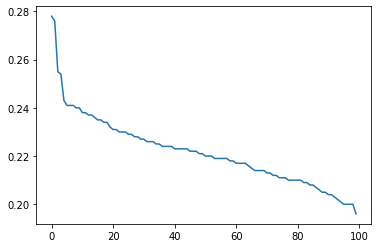

In [109]:
t = [0.237, 0.241, 0.223, 0.221, 0.278, 0.204, 0.226, 0.23 , 0.229,
       0.217, 0.22 , 0.218, 0.222, 0.243, 0.214, 0.203, 0.229, 0.196,
       0.21 , 0.219, 0.227, 0.238, 0.241, 0.211, 0.231, 0.223, 0.226,
       0.217, 0.23 , 0.208, 0.211, 0.21 , 0.24 , 0.231, 0.228, 0.214,
       0.224, 0.219, 0.215, 0.241, 0.217, 0.201, 0.235, 0.21 , 0.214,
       0.226, 0.214, 0.212, 0.254, 0.204, 0.217, 0.24 , 0.22 , 0.224,
       0.219, 0.205, 0.2  , 0.2  , 0.213, 0.205, 0.208, 0.255, 0.209,
       0.234, 0.21 , 0.2  , 0.212, 0.2  , 0.22 , 0.223, 0.223, 0.234,
       0.225, 0.209, 0.224, 0.219, 0.218, 0.235, 0.21 , 0.223, 0.232,
       0.225, 0.202, 0.23 , 0.236, 0.213, 0.237, 0.228, 0.224, 0.222,
       0.238, 0.211, 0.219, 0.227, 0.206, 0.221, 0.222, 0.216, 0.276,
       0.207]
t = sorted(t)
t.reverse()
plt.plot(t)